General note: this is/should all be consistent with Aiden's code. For the Rosenbluth rule I also wanted to track the loglikelihoods, but that should be the only difference.  I also had some slight aesthetic differences in terms of plotting style.(Also hence any differences between some of these plots and the summary slide plots). Again, otherwise it should be consistent.

#**0) Standard Imports & Mount Drive**

In [1]:
#imports

# Plotting program
import matplotlib.pyplot as plt

# Search for files
from glob import glob

# Better math, numbers, and array functions
import numpy as np

# Ignore overflow warnings
import warnings
warnings.filterwarnings('ignore')

# Astropy tools
from astropy.io import ascii
from astropy.io import fits # Reads tables
from astropy.table import Table
import astropy.units as u
import astropy.constants as const

from scipy import interpolate
from scipy.optimize import curve_fit

import random
import copy

#Install corner for corner plots
!pip install corner
import corner

import pandas as pd
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.rcParams['font.family'] = 'DejaVu Serif'

In [2]:
# Mount Drive
# Give permission to the notebook to access files stored in your Google Drive.
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

#Define directories
dir_drive = "/content/gdrive/My Drive/"
dir_astrostats = dir_drive + "2024-25/Astrostats/"

SED = dir_astrostats + 'Copy_SED.dat'

Mounted at /content/gdrive


#**1) Write down your equations for likelihood and/or $χ^2$, priors, & model**

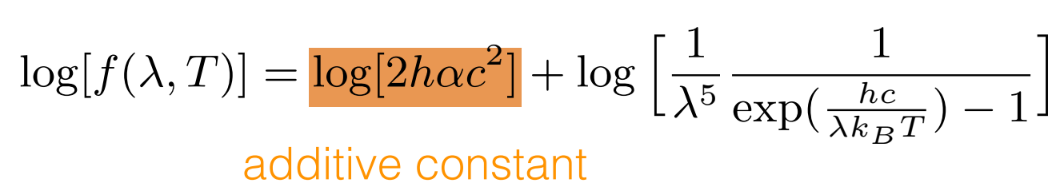

In [3]:
#model
def model(lam, theta):
    temp = theta[0]
    logfactor = theta[1]
    lam = lam.to(u.m).value
    h = const.h.value
    c = const.c.value
    k = const.k_B.value
    frac1 = 1 / lam**5
    frac2 = 1 / (np.exp((h * c) / (lam * k * temp)) - 1)
    return logfactor + np.log10(frac1 * frac2)

In [4]:
#chi2 function
def chi_squared(r, errors):
    sum = 0
    for i in range(len(r)):
        ratio = r[i] / errors[i]
        sum += ratio**2
    return sum

#residuals function
def residuals(y_obs, y_pred):
    return [y_obs[i] - y_pred[i] for i in range(len(y_obs))]

#loglikelihood function
def loglikelihood(r, errors):
    N = len(r)
    term1 = (1/2) * np.log(2 * np.pi)
    term2 = 0
    for i in range(N):
        term2 += np.log(errors[i])
    term3 = chi_squared(r, errors)
    loglike = - term1 - term2 - ((1/2) * term3)

    return loglike


In [5]:
#priors func
def logpriors(theta, thetashape, T_range=[200,500], beta_range=[-100,0]):
    log_priors = [] #initialize array

    for i in range(thetashape):

        if i == 1: #beta
            if beta_range[0] <= theta[i] <= beta_range[1]:
                log_priors.append(0) #log-uniform
            else:
                return -np.inf #not in the range

        elif i == 0: #temperature
            if T_range[0] < theta[i] < T_range[1]:
                log_priors.append(0) #uniform
            else:
                return -np.inf #not in the range

    return np.sum(log_priors)

#**2) Import data**

In [6]:
#Get data
data = ascii.read(SED, data_start=4)
lam_data = (data['col1'] * u.micron) #wavelength
logf_data = data['col2'] #log10(flux)
errlogf = data['col3'] #error on log10(flux)

#**3) Initialize from a random point and compute log-like (log-posterior) - tip: make a plot of your data vs the model guess and check chi^2**

In [36]:
#get a chi2, loglike with a random point
theta = [260, -40]
lam_arr_cont = np.arange(min(lam_data.value), max(lam_data.value)+1, 0.01)*u.micron
flux_arr_model = model(lam_data, theta=theta)
flux_arr_cont = [model(l, theta=theta) for l in lam_arr_cont]
r_arr = residuals(logf_data, flux_arr_cont)
chi2 = chi_squared(r_arr, errlogf)
print(chi2)

9816.462245982606


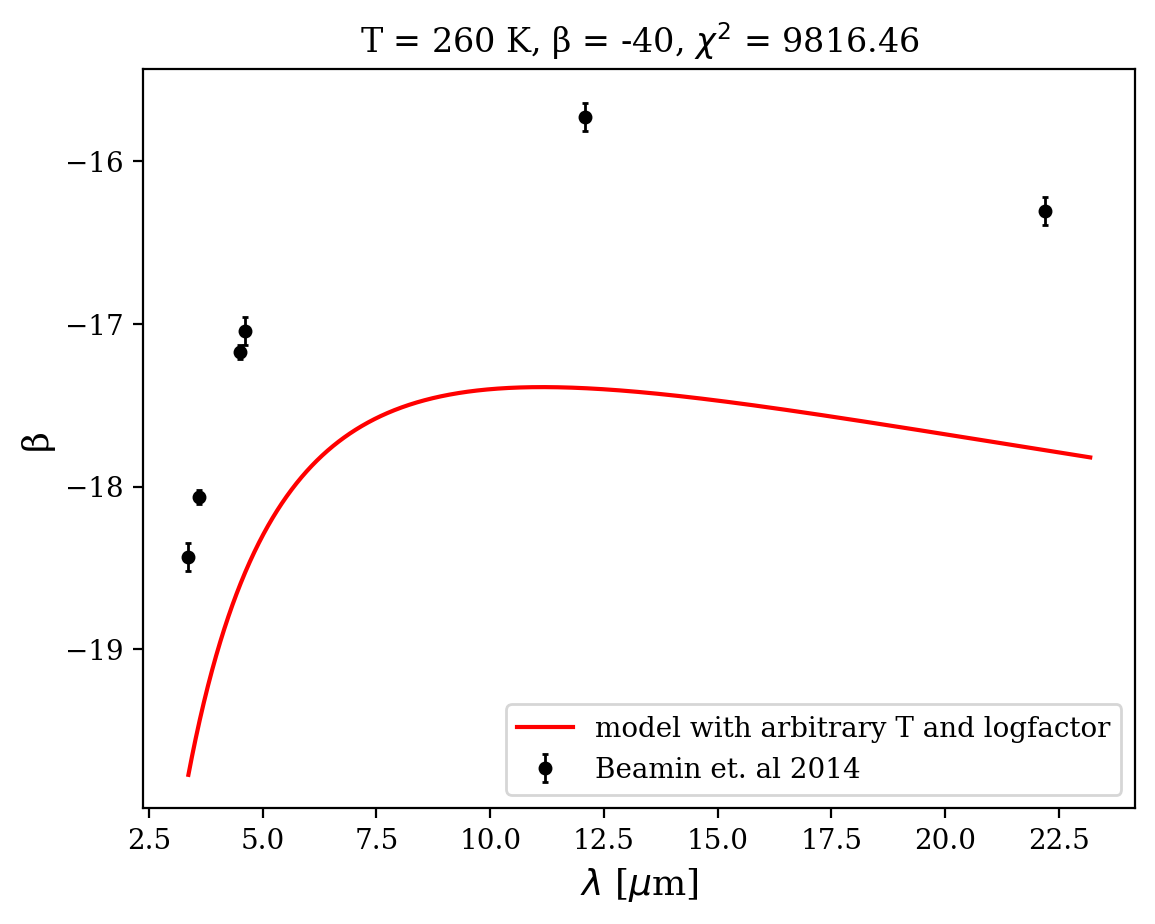

In [37]:
#make a plot with data and model, check that the model has the right shape
fs = 13
plt.errorbar(lam_data, logf_data, yerr=errlogf, fmt='o', c='k', markersize=4, elinewidth=1, capsize=1, label='Beamin et. al 2014')
#plt.scatter(lam_data, flux_arr_cont, c='r', s=20, label='model')
plt.plot(lam_arr_cont, flux_arr_cont, c='r', label = 'model with arbitrary T and logfactor')
plt.xlabel(r'$\lambda$ [$\mu$m]', fontsize=fs)
plt.ylabel('β', fontsize=fs)
plt.legend()
plt.title(f'T = {theta[0]} K, β = {theta[1]}, $\chi^2$ = {round(chi2, 2)}')
plt.show()

# **4 + 5) Walk from there using Rosenbluth and Gaussian proposals**

In [38]:
def init_theta(T_range, beta_range):
    T = np.random.uniform(T_range[0], T_range[1])
    beta = np.random.uniform(beta_range[0], beta_range[1])
    return T, beta

def rosenbluth(modelfunc, N, x0, y0, stds, lam_arr=lam_data, flux_arr=logf_data, errors=errlogf):
    #initialize returns
    samples = [[x0, y0]]
    accepted_chi_squareds = []
    accepted_posteriors = []
    accepted = 0

    #initalize values
    current_x = x0
    current_y = y0
    current_model = [modelfunc(l, [x0, y0]) for l in lam_arr]
    current_residuals = residuals(flux_arr, current_model)
    current_loglike = loglikelihood(current_residuals, errors)
    current_logprior = logpriors([current_x, current_y], 2)
    current_chi2 = chi_squared(current_residuals, errors)

    for i in range(N):
        trial_x = current_x + np.random.normal(0, stds[0])
        trial_y = current_y + np.random.normal(0, stds[1])
        trial_model = [modelfunc(l, [trial_x, trial_y]) for l in lam_arr]
        trial_residuals = residuals(flux_arr, trial_model)
        trial_loglike = loglikelihood(trial_residuals, errors)

        trial_logprior = logpriors([trial_x, trial_y], 2)

        if trial_logprior != -np.inf: #only do anything if the proposal is in bounds

            logR = (trial_loglike + trial_logprior) - (current_loglike + current_logprior)

            if logR > 0:
                accept_prob = 1
            else:
                accept_prob = np.exp(logR)

        else: #acceptance probability is 0 if out of bounds
            accept_prob = 0

        if accept_prob > np.random.uniform(0,1):
            current_x = trial_x
            current_y = trial_y
            current_model = [modelfunc(l, [current_x, current_y]) for l in lam_arr]
            current_residuals = residuals(flux_arr, current_model)
            current_loglike = loglikelihood(current_residuals, errors)
            current_logprior = logpriors([current_x, current_y], 2)
            current_chi2 = chi_squared(current_residuals, errors)
            samples.append([current_x, current_y])
            accepted_chi_squareds.append(current_chi2)
            accepted += 1
        else:
            continue

    accept_ratio = accepted / N

    return np.array(samples), accepted_chi_squareds, loglikes, accept_ratio

In [39]:
#test

#initialize random point
T_range = [200, 500] #range for Y dwarfs
beta_range = [-100, 0]
T0, beta0 = init_theta(T_range, beta_range)

#run with 100,000 steps
N = 100000
samples, accepted_chi_squareds, loglikes, accept_ratio = rosenbluth(model, N, T0, beta0, stds=[5,0.1])

In [40]:
# Print results
print("Samples:\n", samples)
print("Log-likelihoods:\n", loglikes)
print("Chi-Squareds:\n", accepted_chi_squareds)
print("Accepted proposals ratio:\n", accept_ratio)

Samples:
 [[297.05620579 -15.76124319]
 [291.28051417 -15.72817754]
 [292.77522083 -15.75588429]
 ...
 [248.47085079 -38.33296369]
 [248.99798852 -38.3272606 ]
 [253.5435813  -38.44106488]]
Log-likelihoods:
 [-19213.274174916398, -18531.073601383876, -17274.326308447547, -17066.516377221604, -16620.188439415462, -16250.963262708452, -15226.456995236453, -15225.711025717932, -13451.240195728558, -12819.95402457156, -12740.317333259845, -12375.785237462102, -12244.953105541195, -11898.668721892396, -11133.630181253777, -10791.331525695296, -10110.184624367801, -9390.540393410653, -8738.913961114333, -7969.871188760147, -7534.06750366971, -7065.831001467964, -6785.146390929023, -6599.518805740514, -6368.29571422988, -6015.470934166508, -5722.563135298012, -5539.747753722619, -5142.177483119325, -5051.809057760911, -4600.135243325909, -4529.560865851555, -4199.382378470295, -4199.993159279704, -3999.5796852384497, -3796.5744485170612, -3351.9016192967683, -3173.6237900314177, -3031.0542899

Text(0.5, 1.0, '$\\chi^2$ of accepted jumps')

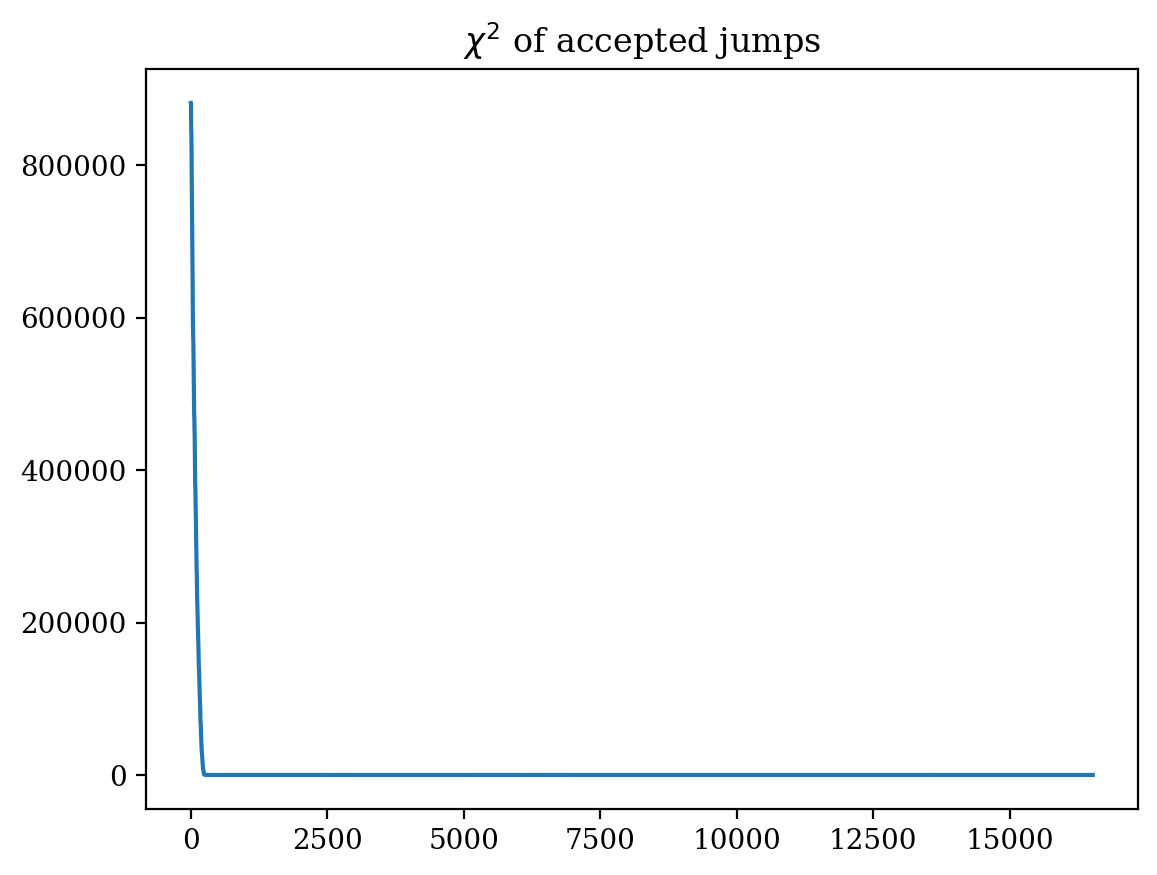

In [41]:
plt.plot(np.arange(1,len(accepted_chi_squareds)+1), accepted_chi_squareds)
plt.title('$\chi^2$ of accepted jumps')

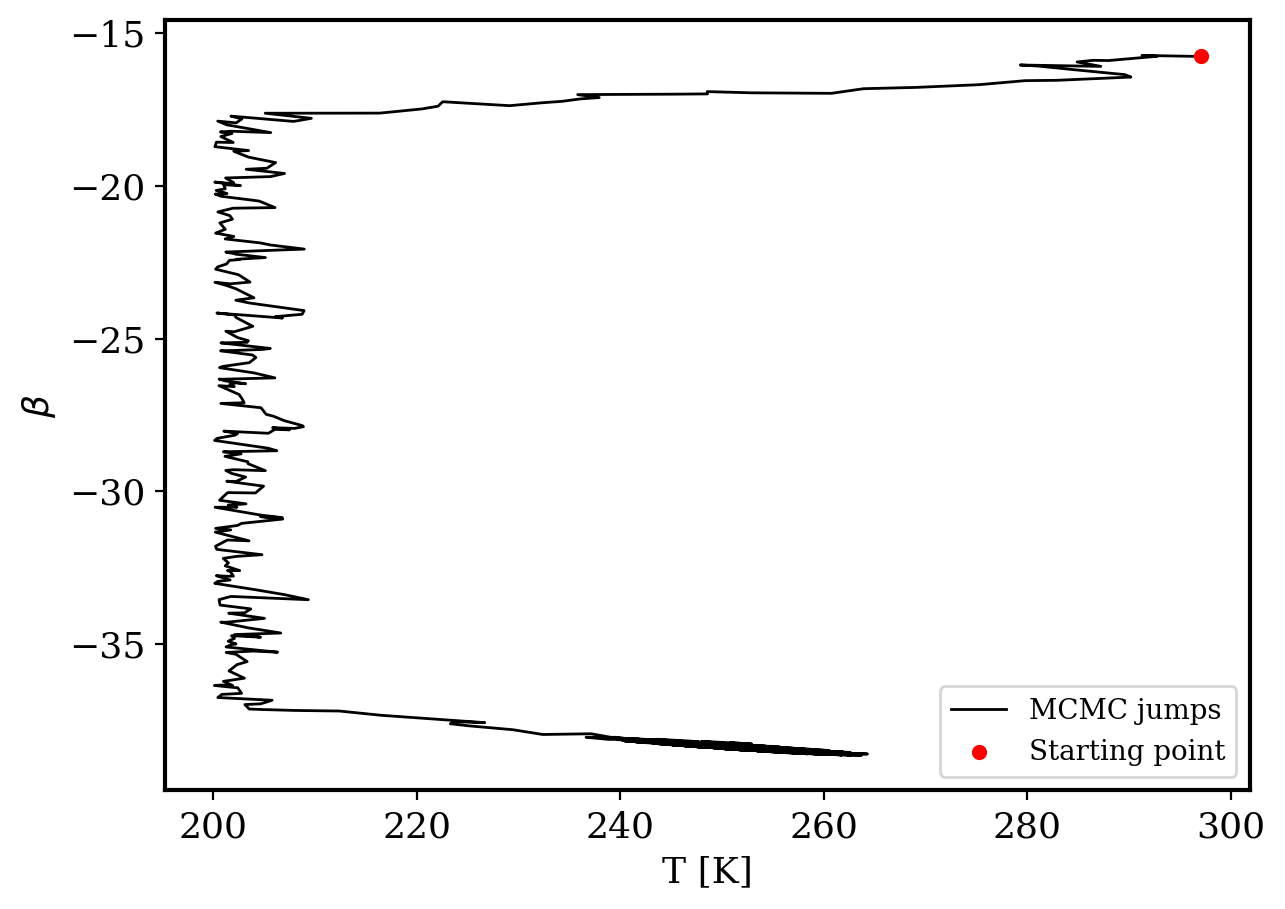

In [42]:
#plot results
figure, axis = plt.subplots(figsize=(7,5))

axis.plot(samples[:,0], samples[:,1], c='k', lw=1, zorder=0, label='MCMC jumps') #starting point
axis.scatter(T0,beta0, s=20, c='r', zorder=1, label='Starting point')
axis.set_xlabel('T [K]', fontsize=fs)
axis.set_ylabel(r'$\beta$', fontsize=fs)
plt.legend()


axis_border_width = 1.5
fontsize_axis_labels = 13
axis.tick_params(axis='both', which='major', labelsize=fontsize_axis_labels)
axis.spines['top'].set_linewidth(axis_border_width)
axis.spines['left'].set_linewidth(axis_border_width)
axis.spines['right'].set_linewidth(axis_border_width)
axis.spines['bottom'].set_linewidth(axis_border_width)

plt.show()

#**6 + 7) Once a good MCMC has run, filter out the burn-in points; Make some nice plots proving i) burnt-in ii) good mixing and then your posteriors as a histogram**

##**Mixing**

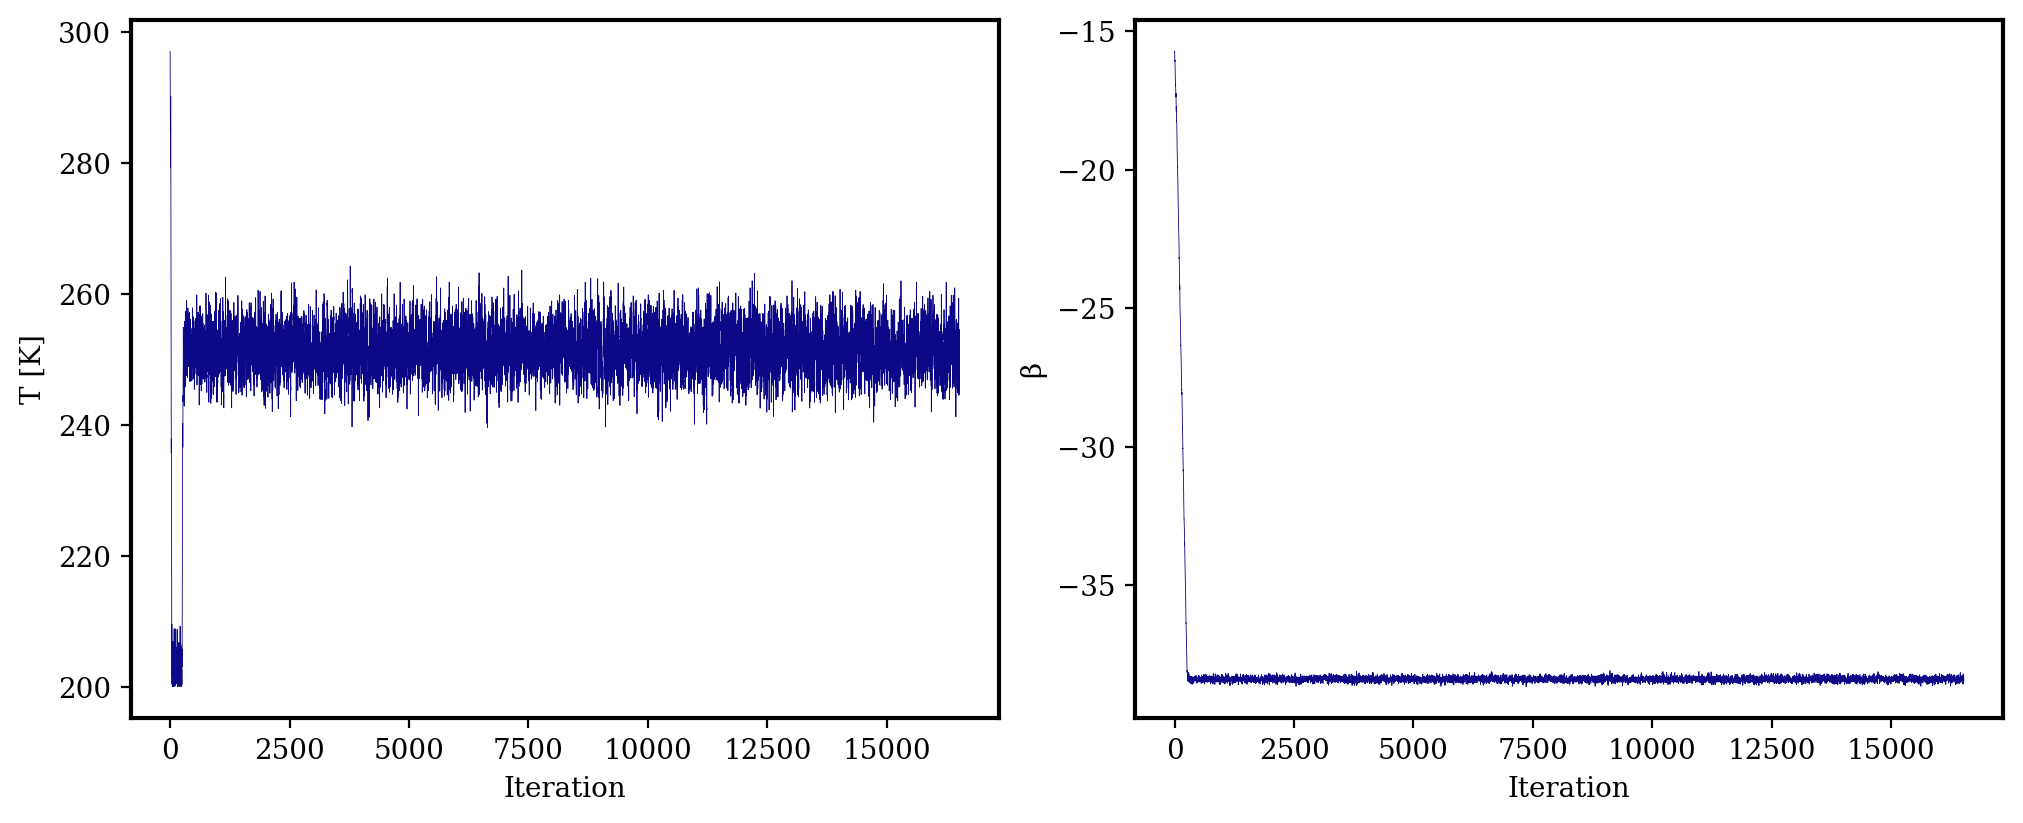

In [43]:
#plot mixing -- ok log factor might be converging?
iterations = np.arange(0,len(samples))

fig, ax = plt.subplots(1,2,figsize=(10,4),constrained_layout=True)

ax[0].plot(iterations, samples[:,0], lw=0.3, c='#0d0887')
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('T [K]')

ax[1].plot(iterations, samples[:,1], lw=0.3, c='#0d0887')
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('β')


axis_border_width = 1.5
fontsize_axis_labels = 13
#ax.tick_params(axis='both', which='major', labelsize=fontsize_axis_labels)
ax[0].spines['top'].set_linewidth(axis_border_width)
ax[0].spines['left'].set_linewidth(axis_border_width)
ax[0].spines['right'].set_linewidth(axis_border_width)
ax[0].spines['bottom'].set_linewidth(axis_border_width)

ax[1].spines['top'].set_linewidth(axis_border_width)
ax[1].spines['left'].set_linewidth(axis_border_width)
ax[1].spines['right'].set_linewidth(axis_border_width)
ax[1].spines['bottom'].set_linewidth(axis_border_width)

In [44]:
#get a chi2, loglike with a random point
theta = [samples[:,0][-1], samples[:,1][-1]]
lam_arr_cont = np.arange(min(lam_data.value), max(lam_data.value)+1, 0.01)*u.micron
flux_arr_model = model(lam_data, theta=theta)
flux_arr_cont = [model(l, theta=theta) for l in lam_arr_cont]
r_arr = residuals(logf_data, flux_arr_cont)
chi2 = chi_squared(r_arr, errlogf)
print(chi2)

2458.6198318889064


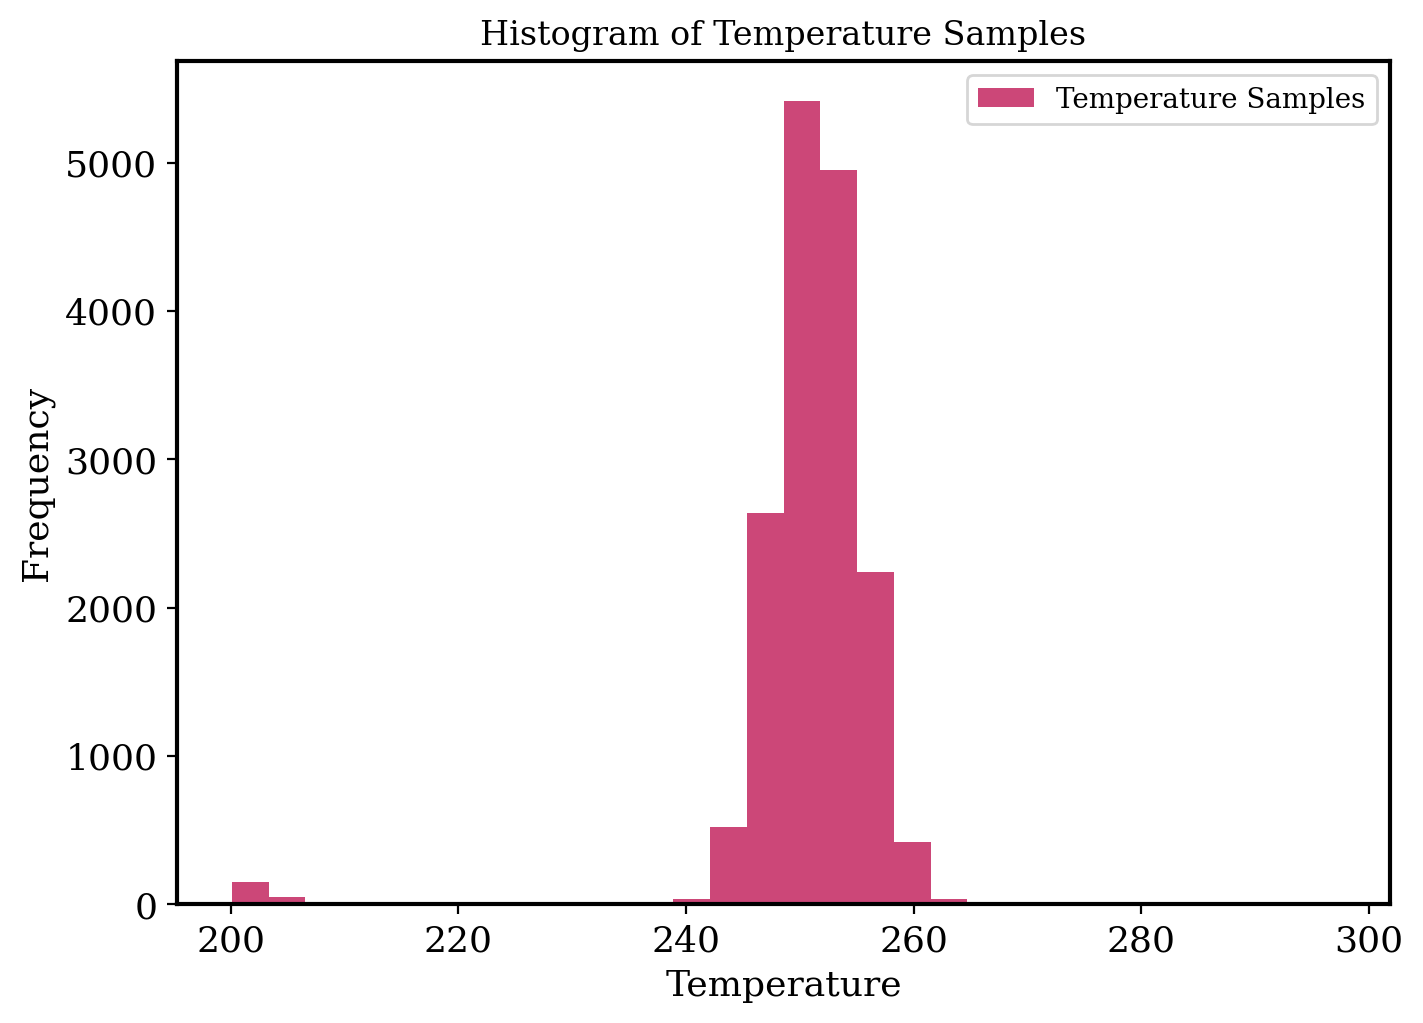

In [45]:
fig, ax = plt.subplots(figsize=(7,5),constrained_layout=True)
ax.hist(samples[:, 0], bins=30, label='Temperature Samples', color='#cc4778')
ax.set_xlabel('Temperature', fontsize  = fs)
ax.set_ylabel('Frequency', fontsize = fs)
ax.set_title('Histogram of Temperature Samples')
plt.legend()

#Standard code to make the plots pretty
axis_border_width = 1.5
fontsize_axis_labels = fs
ax.tick_params(axis='both', which='major', labelsize=fontsize_axis_labels)
ax.spines['top'].set_linewidth(axis_border_width)
ax.spines['left'].set_linewidth(axis_border_width)
ax.spines['right'].set_linewidth(axis_border_width)
ax.spines['bottom'].set_linewidth(axis_border_width)

ax.spines['top'].set_linewidth(axis_border_width)
ax.spines['left'].set_linewidth(axis_border_width)
ax.spines['right'].set_linewidth(axis_border_width)
ax.spines['bottom'].set_linewidth(axis_border_width)

plt.show()



##**Burn-in**

In [46]:
# Number of burn-in samples to discard
n_burn = 1000

# Test the metropolis function
#T0 = 240
#logfactor0 = -20
samples, accepted_chi_squareds, loglikes, accept_ratio = rosenbluth(model, N, T0, beta0, stds=[10,0.1])

# Discard the burn-in samples
samples_burned = samples[n_burn:]
loglikes_burned = loglikes[n_burn:]
chi_squareds_burned = accepted_chi_squareds[n_burn:]

# Print the results after burn-in
print("Samples after burn-in:\n", samples_burned)
print("Log-likelihoods after burn-in:\n", loglikes_burned)
print("Chi-squareds after burn-in:\n", chi_squareds_burned)


Samples after burn-in:
 [[253.36163088 -38.42934641]
 [253.58547832 -38.4699183 ]
 [257.18129601 -38.48227516]
 ...
 [250.95020339 -38.37909981]
 [251.68885976 -38.41587304]
 [252.16588106 -38.36608043]]
Log-likelihoods after burn-in:
 [12.96895235903924, 12.789102982597576, 12.904534663623163, 12.240678808613133, 11.932594208104817, 13.090094181643064, 12.684294343890105, 12.629405690731936, 12.826842579644621, 12.746064030686725, 12.969969942556922, 12.68071870075686, 12.20738674285074, 11.522909774710024, 12.173952687268475, 11.85313921807671, 13.075820524413706, 11.136104023516209, 12.681067205986583, 12.09326837889635, 12.43825583417294, 12.719263802277105, 12.81734098254487, 10.65164326839035, 12.401202329534392, 13.028085414307315, 13.01354211166223, 12.93446897978723, 12.95508062971886, 11.78201852467564, 11.849090424642442, 9.456427465081715, 9.42915593887311, 12.648766214995213, 12.418301450097427, 11.406291742336826, 12.99413897704677, 12.914607214055117, 12.744539162574705,

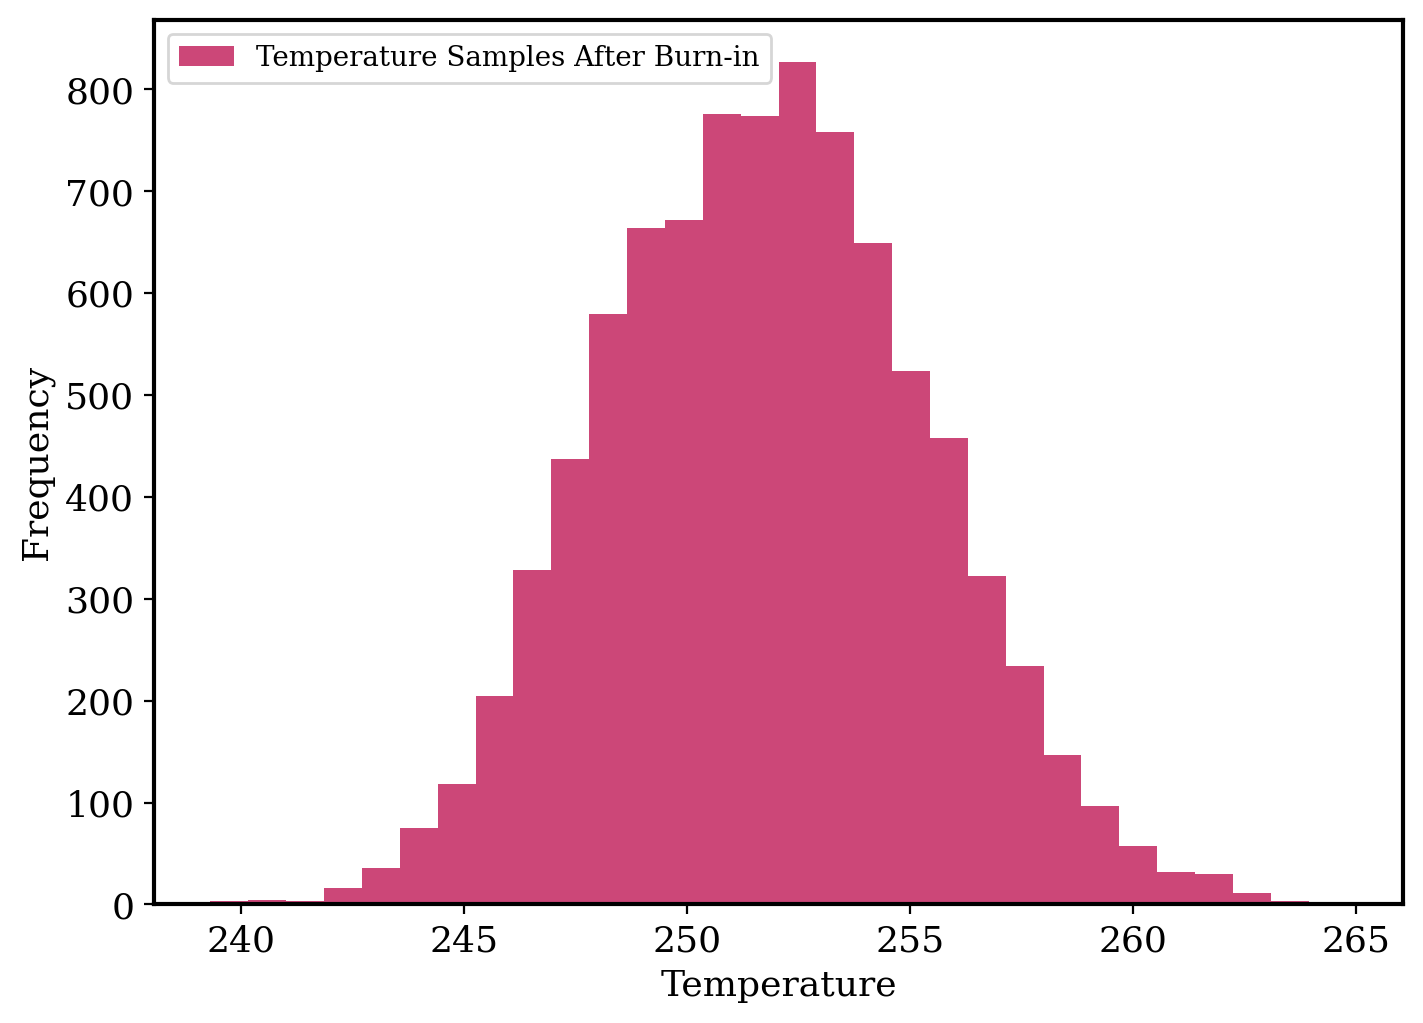

In [47]:
fig, ax = plt.subplots(figsize=(7,5),constrained_layout=True)

ax.hist(samples_burned[:, 0], bins=30, label='Temperature Samples After Burn-in', color='#cc4778')
ax.set_xlabel('Temperature', fontsize  = fs)
ax.set_ylabel('Frequency', fontsize = fs)
#ax.set_title('Histogram of Temperature Samples')
plt.legend()

#Standard code to make the plots pretty
axis_border_width = 1.5
fontsize_axis_labels = fs
ax.tick_params(axis='both', which='major', labelsize=fontsize_axis_labels)
ax.spines['top'].set_linewidth(axis_border_width)
ax.spines['left'].set_linewidth(axis_border_width)
ax.spines['right'].set_linewidth(axis_border_width)
ax.spines['bottom'].set_linewidth(axis_border_width)

ax.spines['top'].set_linewidth(axis_border_width)
ax.spines['left'].set_linewidth(axis_border_width)
ax.spines['right'].set_linewidth(axis_border_width)
ax.spines['bottom'].set_linewidth(axis_border_width)

plt.show()

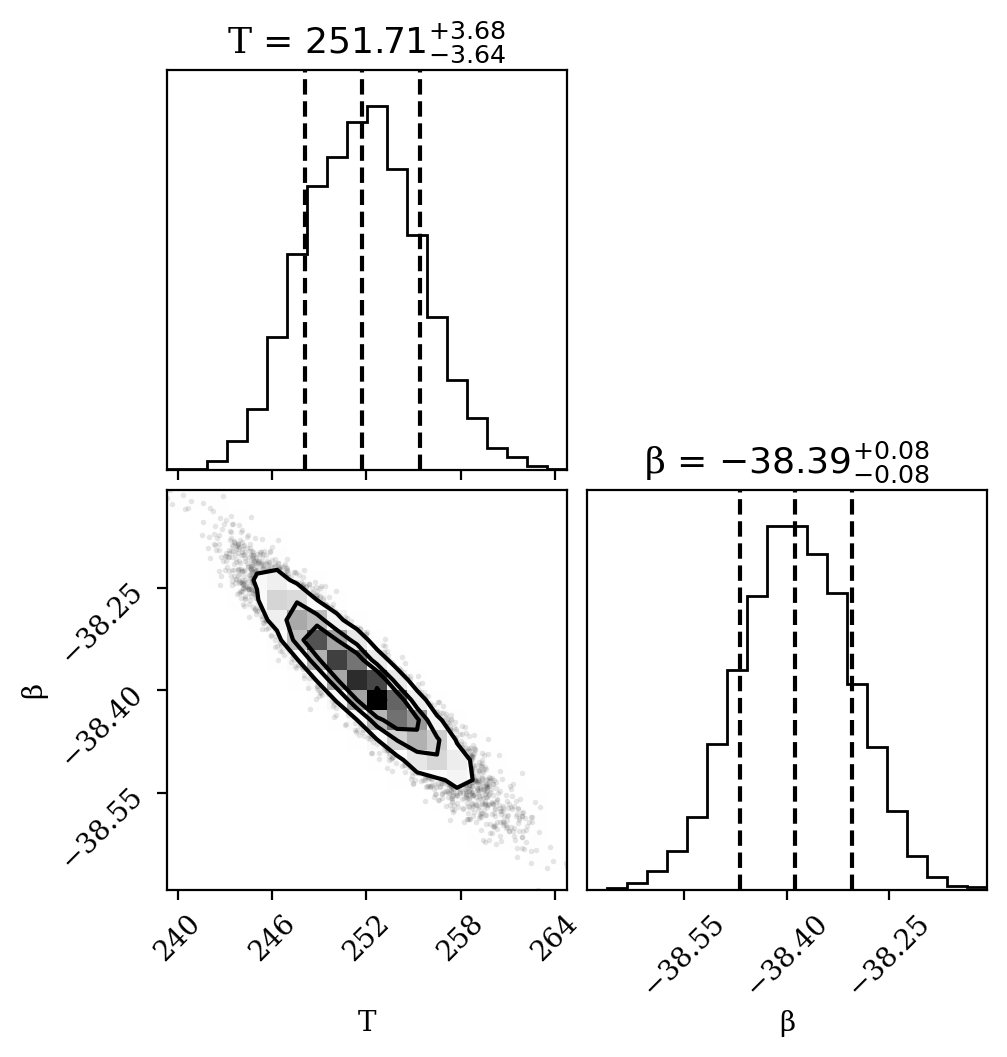

In [48]:
#posteriors cornerplot / histograms
mean_beta, mean_T = np.mean(samples_burned[:, 1]), np.mean(samples_burned[:, 0])
std_beta, std_T = np.std(samples_burned[:, 1]), np.std(samples_burned[:, 0])
mean_chi2 = np.mean(chi_squareds_burned)

# Correct labels according to the column order of `samples_burned`
labels = [r"T", r"β", r"$\log_{10}(f)$"]
fig = corner.corner(
    samples_burned,
    labels=labels,
    quantiles=[0.16, 0.5, 0.84],  # lines for +/- 1 std and mean
    show_titles=True,
    title_kwargs={"fontsize": fs}
)

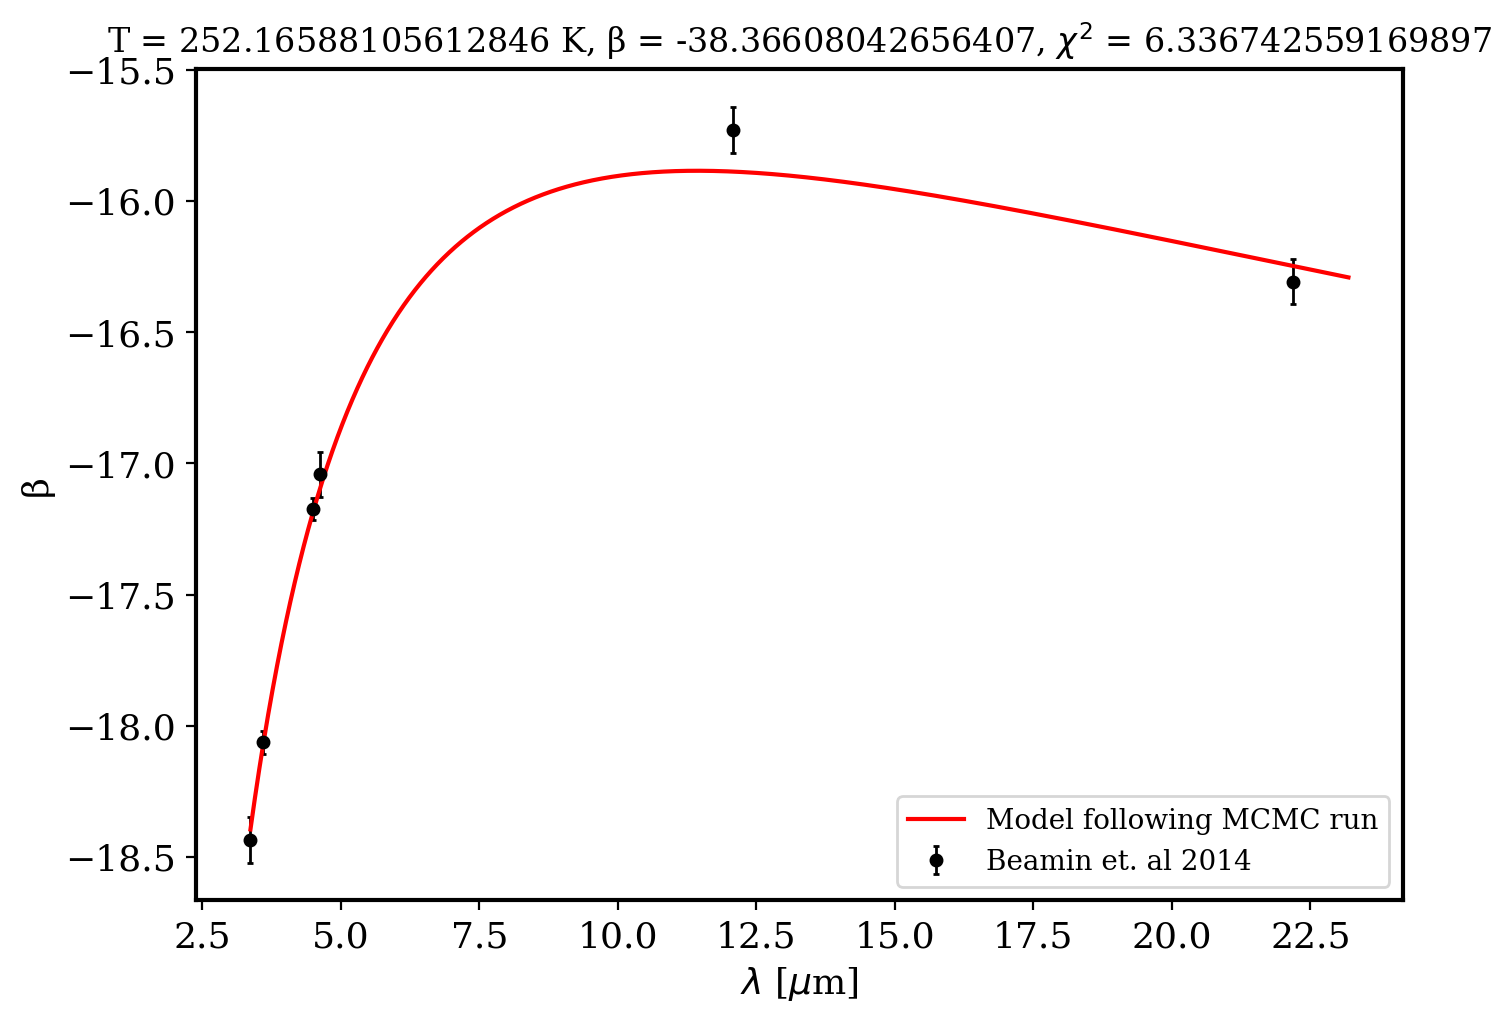

In [52]:
#make a plot with data and model following the MCMC run after burn-in
fig, ax = plt.subplots(figsize=(7,5),constrained_layout=True)

fs = 13
ax.errorbar(lam_data, logf_data, yerr=errlogf, fmt='o', c='k', markersize=4, elinewidth=1, capsize=1, label='Beamin et. al 2014')
ax.plot(lam_arr_cont, flux_arr_cont, c='r', label = 'Model following MCMC run')
ax.set_xlabel(r'$\lambda$ [$\mu$m]', fontsize=fs)
ax.set_ylabel('β', fontsize=fs)
plt.legend()
ax.set_title(f'T = {samples[:,0][-1]} K, β = {samples[:,1][-1]}, $\chi^2$ = {mean_chi2}')

#Standard code to make the plots pretty
axis_border_width = 1.5
fontsize_axis_labels = fs
ax.tick_params(axis='both', which='major', labelsize=fontsize_axis_labels)
ax.spines['top'].set_linewidth(axis_border_width)
ax.spines['left'].set_linewidth(axis_border_width)
ax.spines['right'].set_linewidth(axis_border_width)
ax.spines['bottom'].set_linewidth(axis_border_width)

ax.spines['top'].set_linewidth(axis_border_width)
ax.spines['left'].set_linewidth(axis_border_width)
ax.spines['right'].set_linewidth(axis_border_width)
ax.spines['bottom'].set_linewidth(axis_border_width)

plt.show()

#**8*) Combine multiple chains from independent seeds**

In [67]:
def multiple_chains(seeds, mcmc_func, mcmc_params):
    #mcmc_params = [model, N, stds], seeds provided separately
    samples_arr = []
    chi2_arr = []
    loglikes_arr = []
    ratio_arr = []

    for i in range(len(seeds)):

        T0 = seeds[i][0]
        beta0 = seeds[i][1]
        samples, chi2, loglikes, accept_ratio = mcmc_func(mcmc_params[0], mcmc_params[1], T0, beta0, mcmc_params[2])
        samples_arr.append(samples)
        chi2_arr.append(chi2)

    return samples_arr, chi2_arr, loglikes_arr, ratio_arr

def init_multiple_chains(N_chains):
    seeds = []
    for i in range(N_chains):
        T0, beta0 = init_theta(T_range, beta_range)
        seeds.append([T0, beta0])

    return np.array(seeds)

In [70]:
#run multiple chains of 100,000
N_chains = 10
seeds = init_multiple_chains(N_chains)

params = [model, 100000, [10,0.1]]
chain_samples, chain_chi2, chain_loglike, chain_ratio = multiple_chains(seeds, rosenbluth, params)

In [71]:
#cut off at ind=2000 to play it safe and just get rid of the burn in for everything at once, we have enough steps that this doesn't make the results worse
chain_samples_final = []
chain_chi2_final = []
for i in range(N_chains):
    samples = chain_samples[i][2000:]
    chi2 = chain_chi2[i][2000:]
    chain_samples_final.append(samples)
    chain_chi2_final.append(chi2)

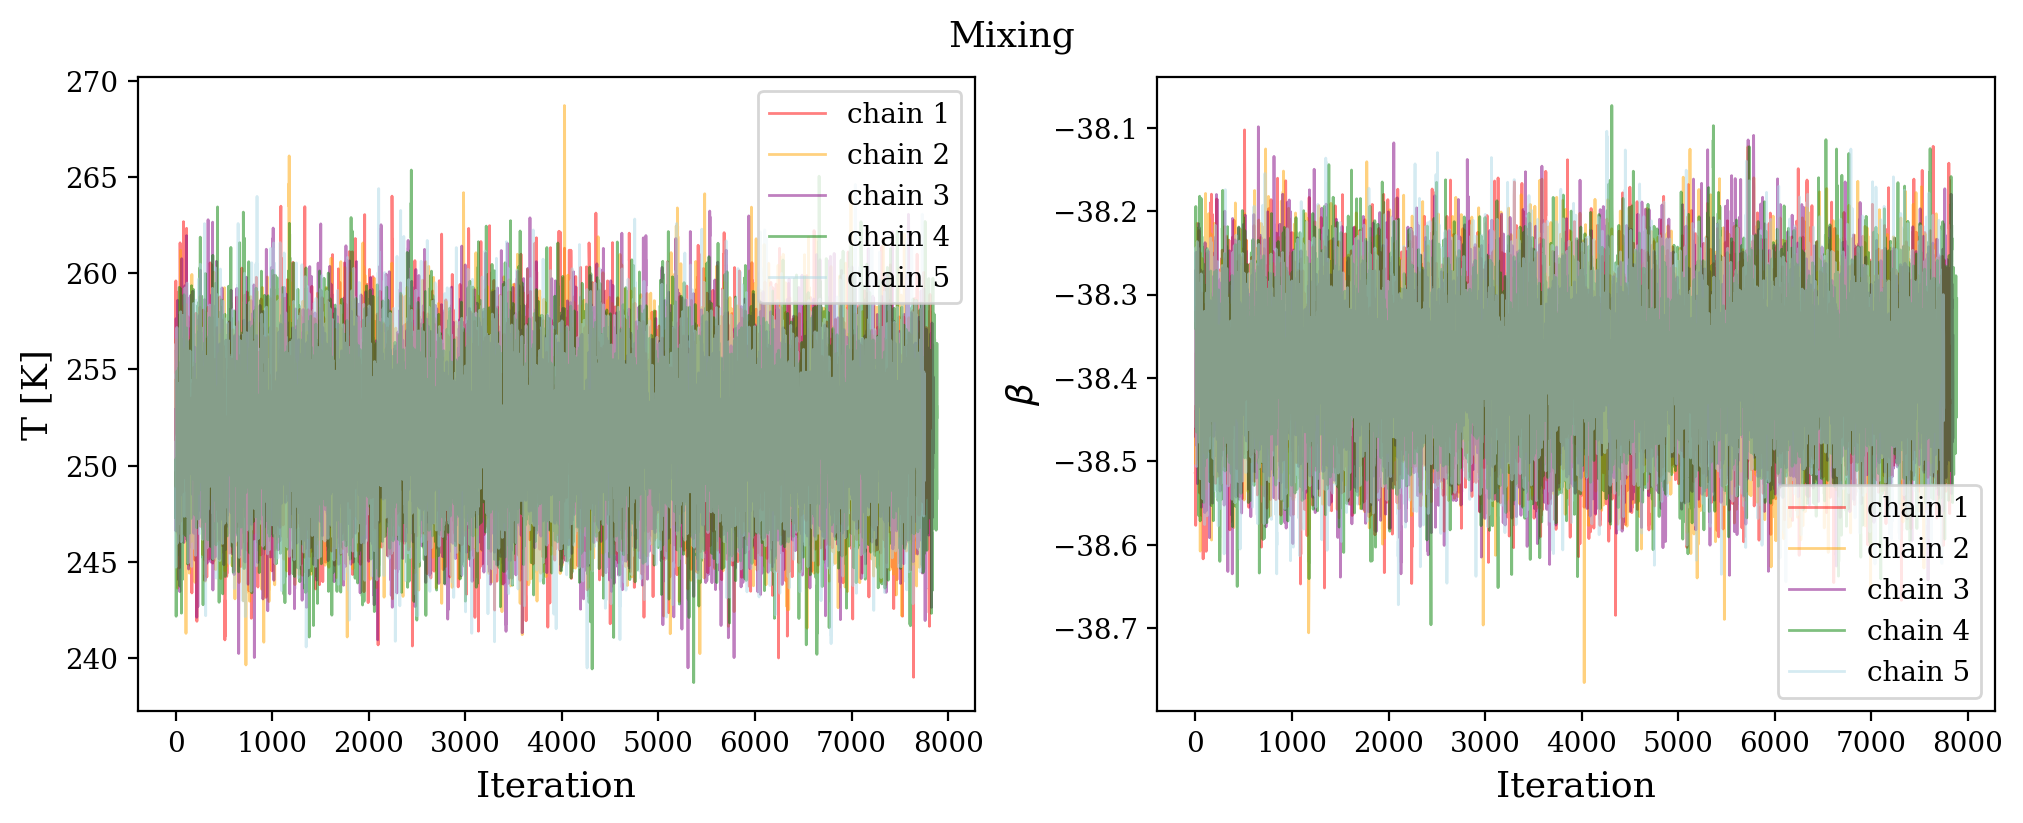

In [90]:
#plot mixing with multiple chains (only doing first 5 because it gets redundant after that)
iterations = []
for i in range(N_chains):
    iteration = np.arange(0,len(chain_samples_final[i]))
    iterations.append(iteration)
alpha=0.5

fig, ax = plt.subplots(1,2,figsize=(10,4),constrained_layout=True)
fig.suptitle('Mixing', fontsize=fs)

ax[0].plot(iterations[0], chain_samples_final[0][:,0], lw=1, alpha=alpha, c='r', label='chain 1')
ax[0].plot(iterations[1], chain_samples_final[1][:,0], lw=1, alpha=alpha, c='orange', label='chain 2')
ax[0].plot(iterations[2], chain_samples_final[2][:,0], lw=1, alpha=alpha, c='purple', label='chain 3')
ax[0].plot(iterations[3], chain_samples_final[3][:,0], lw=1, alpha=alpha, c='green', label='chain 4')
ax[0].plot(iterations[4], chain_samples_final[4][:,0], lw=1, alpha=alpha, c='lightblue', label='chain 5')
ax[0].set_xlabel('Iteration', fontsize=fs)
ax[0].set_ylabel('T [K]', fontsize=fs)
ax[0].legend()

ax[1].plot(iterations[0], chain_samples_final[0][:,1], lw=1, alpha=alpha, c='r', label='chain 1')
ax[1].plot(iterations[1], chain_samples_final[1][:,1], lw=1, alpha=alpha, c='orange', label='chain 2')
ax[1].plot(iterations[2], chain_samples_final[2][:,1], lw=1, alpha=alpha, c='purple', label='chain 3')
ax[1].plot(iterations[3], chain_samples_final[3][:,1], lw=1, alpha=alpha, c='green', label='chain 4')
ax[1].plot(iterations[4], chain_samples_final[4][:,1], lw=1, alpha=alpha, c='lightblue', label='chain 5')
ax[1].set_xlabel('Iteration', fontsize=fs)
ax[1].set_ylabel(r'$\beta$', fontsize=fs)
ax[1].legend()
plt.show()

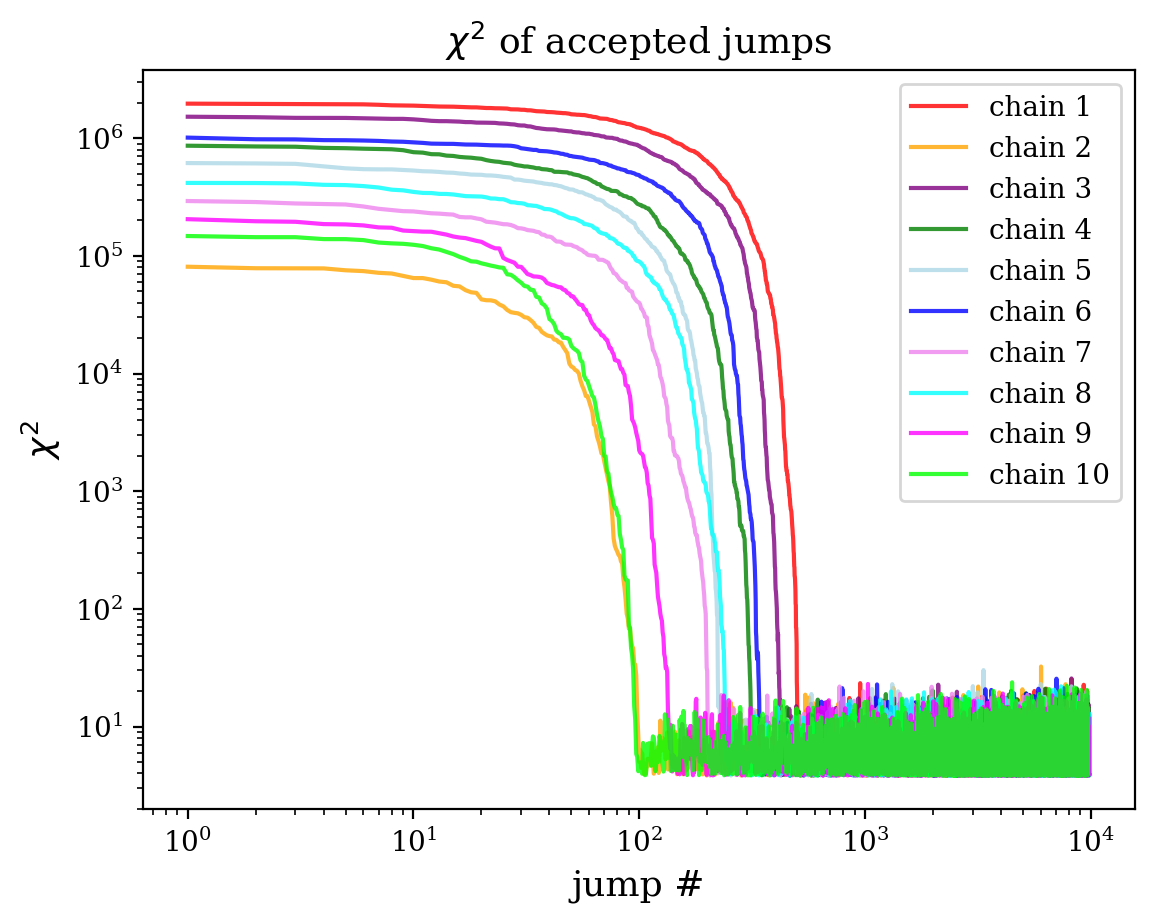

In [73]:
#plot accepted chi2 for chains
chi2_jump_Ns = []
for i in range(N_chains):
    jump_N = np.arange(1,len(chain_chi2[i])+1)
    chi2_jump_Ns.append(jump_N)

alpha=0.8
plt.plot(chi2_jump_Ns[0], chain_chi2[0], c='r', alpha=alpha, label='chain 1')
plt.plot(chi2_jump_Ns[1], chain_chi2[1], c='orange', alpha=alpha, label='chain 2')
plt.plot(chi2_jump_Ns[2], chain_chi2[2], c='purple', alpha=alpha, label='chain 3')
plt.plot(chi2_jump_Ns[3], chain_chi2[3], c='green', alpha=alpha, label='chain 4')
plt.plot(chi2_jump_Ns[4], chain_chi2[4], c='lightblue', alpha=alpha, label='chain 5')
plt.plot(chi2_jump_Ns[5], chain_chi2[5], c='blue', alpha=alpha, label='chain 6')
plt.plot(chi2_jump_Ns[6], chain_chi2[6], c='violet', alpha=alpha, label='chain 7')
plt.plot(chi2_jump_Ns[7], chain_chi2[7], c='cyan', alpha=alpha, label='chain 8')
plt.plot(chi2_jump_Ns[8], chain_chi2[8], c='magenta', alpha=alpha, label='chain 9')
plt.plot(chi2_jump_Ns[9], chain_chi2[9], c='lime', alpha=alpha, label='chain 10')
plt.title('$\chi^2$ of accepted jumps', fontsize=fs)
plt.xlabel('jump #', fontsize=fs)
plt.ylabel(r'$\chi^2$', fontsize=fs)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

In [75]:
#get the means and stds for all chains to find the grand ultimate means and stds
T_arr = []
std_T_arr = []
beta_arr = []
std_beta_arr = []
for i in range(N_chains):
    samples_new = chain_samples_final[i][1:]
    min_chi2 = min(chain_chi2_final)
    min_chi2_ind = chain_chi2_final.index(min_chi2)
    theta_min_chi2 = samples_new[min_chi2_ind]
    T_arr.append(theta_min_chi2[0])
    beta_arr.append(theta_min_chi2[1])

    std_T = np.std(chain_samples_final[i][:,0])
    std_beta = np.std(chain_samples_final[i][:,1])
    std_T_arr.append(std_T)
    std_beta_arr.append(std_beta)
print(fr'''
Average temperature result over 10 chains: {round(np.mean(T_arr),2)} +/- {round(np.mean(std_T_arr),2)} K
Average beta result over 10 chains: {round(np.mean(beta_arr),2)} +/- {round(np.mean(std_beta_arr),2)}
''')


Average temperature result over 10 chains: 252.98 +/- 3.56 K
Average beta result over 10 chains: -38.4 +/- 0.08



In [76]:
#calculate model again based on multiple chain results
theta_multchains = [np.mean(T_arr), np.mean(beta_arr)]
flux_multchains = model(lam_data, theta=theta_multchains) #points
flux_cont_multchains = [model(l, theta=theta_multchains) for l in lam_arr_cont] #continuous line

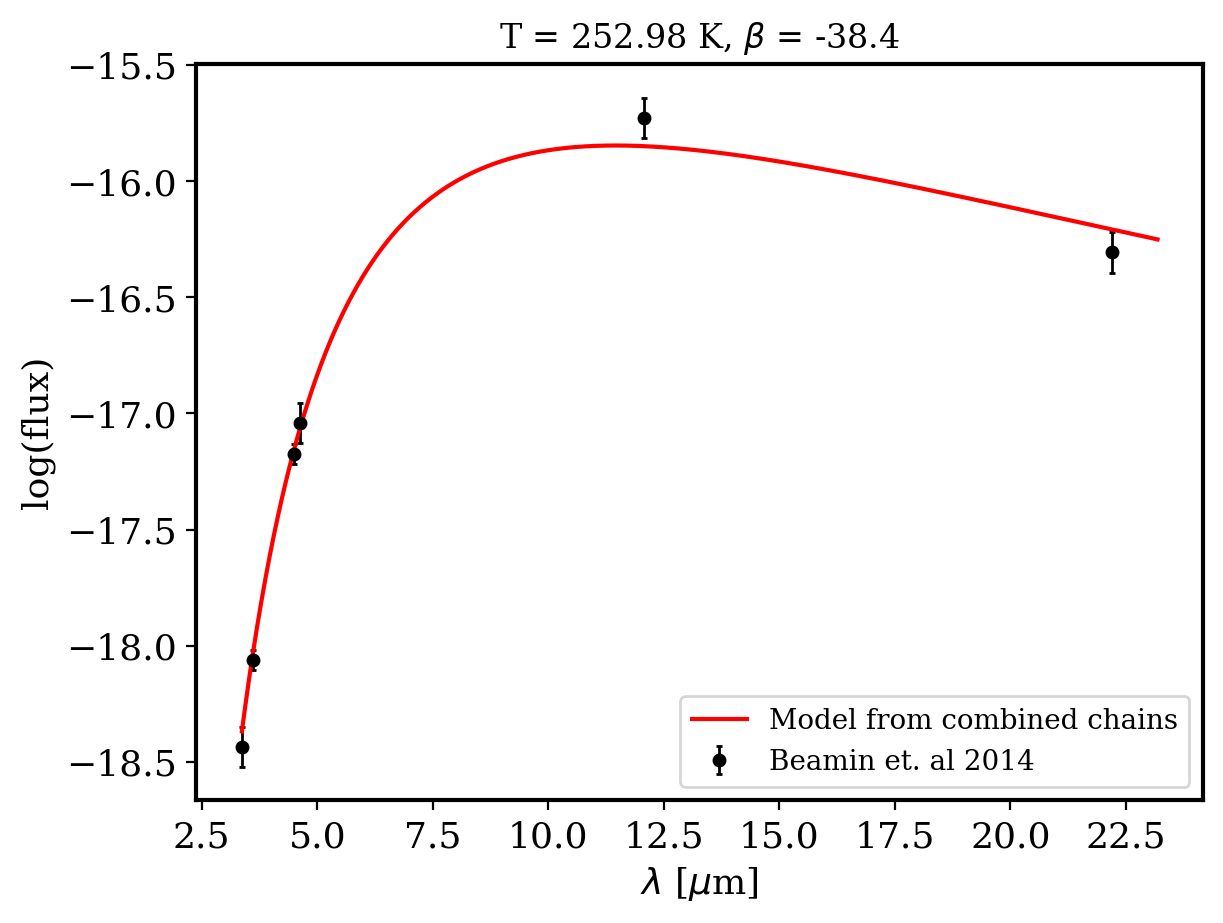

In [88]:
#plot data and fit with 1 sigma interval
fig, ax = plt.subplots(figsize=(6,4.5), constrained_layout=True)
ax.errorbar(lam_data, logf_data, yerr=errlogf, fmt='o', c='k', markersize=4, elinewidth=1, capsize=1, label='Beamin et. al 2014')
ax.plot(lam_arr_cont, flux_cont_multchains, c='r',  label='Model from combined chains')
ax.set_xlabel(r'$\lambda$ [$\mu$m]', fontsize=fs)
ax.set_ylabel('log(flux)', fontsize=fs)
ax.legend()
ax.set_title(fr'T = {round(theta_multchains[0], 2)} K, $\beta$ = {round(theta_multchains[1], 2)}')

axis_border_width = 1.5
fontsize_axis_labels = 13
ax.tick_params(axis='both', which='major', labelsize=fontsize_axis_labels)
ax.spines['top'].set_linewidth(axis_border_width)
ax.spines['left'].set_linewidth(axis_border_width)
ax.spines['right'].set_linewidth(axis_border_width)
ax.spines['bottom'].set_linewidth(axis_border_width)

plt.show()